# Graph Convolutional Networks

## GatedGCNs

Residual Gated Graph ConvNets, X Bresson, T Laurent, ICLR 2018, [arXiv:1711.07553](https://arxiv.org/pdf/1711.07553v2.pdf) <br>


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS6208_codes/codes/labs_lecture05'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd

In [1]:
# Import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    

# Collate function to prepare graphs

In [2]:

# collate function 
def collate(samples):
    graphs, labels = map(list, zip(*samples)) # samples is a list of pairs (graph, label).
    labels = torch.tensor(labels)
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))] # graph sizes
    tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    snorm_n = torch.cat(tab_snorm_n).sqrt() # graph size normalization 
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))] # nb of edges
    tab_snorm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    snorm_e = torch.cat(tab_snorm_e).sqrt() # graph size normalization
    batched_graph = dgl.batch(graphs) # batch graphs
    return batched_graph, labels, snorm_n, snorm_e


# create artifical data feature (= in degree) for each node
def create_artificial_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()
        graph.edata['feat'] = torch.ones(graph.number_of_edges(),1)
    return dataset


# generate artifical graph dataset with DGL
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = create_artificial_features(trainset)
testset = create_artificial_features(testset)
valset = create_artificial_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(0))


# Visualize graph dataset

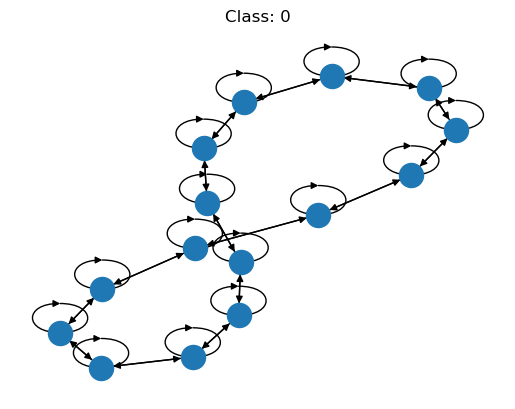

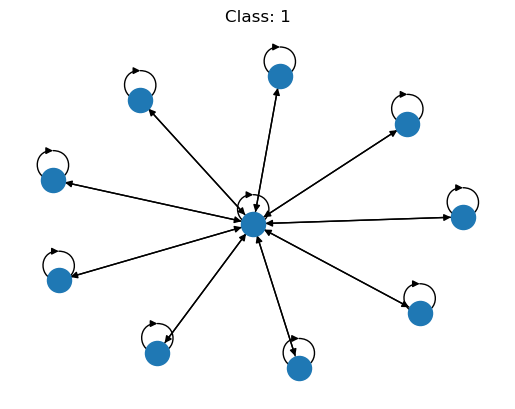

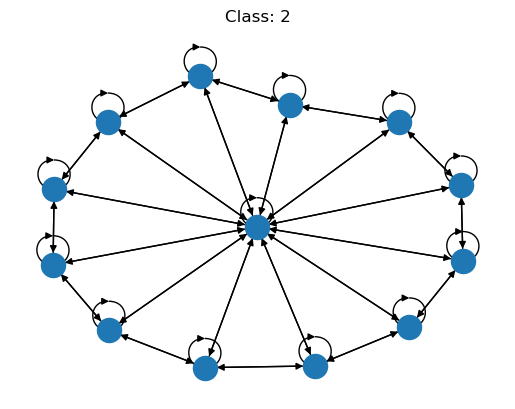

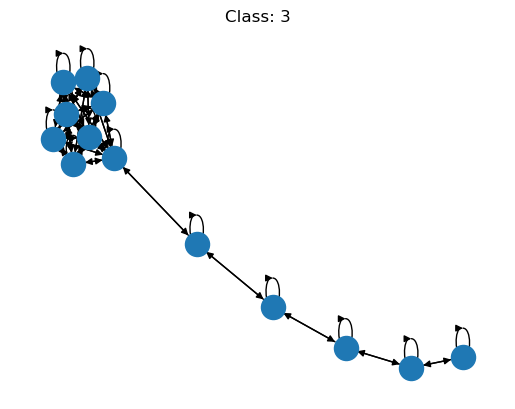

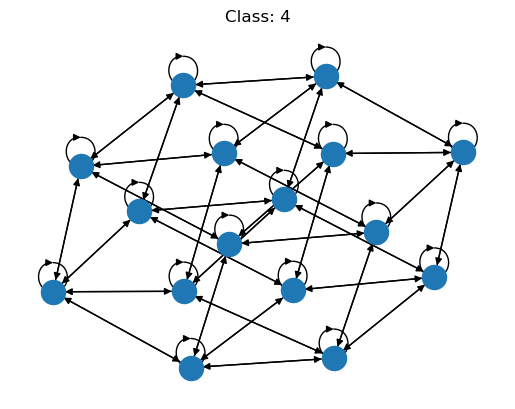

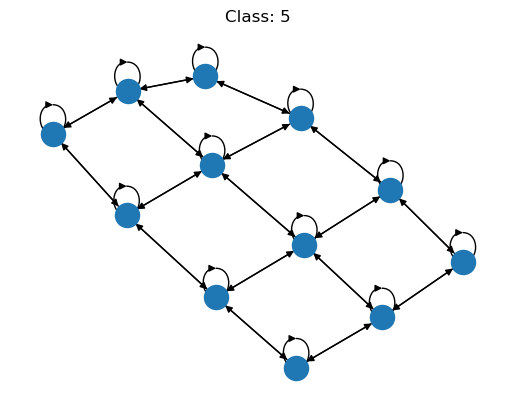

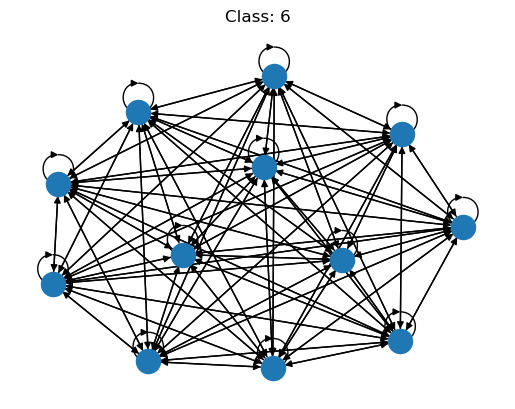

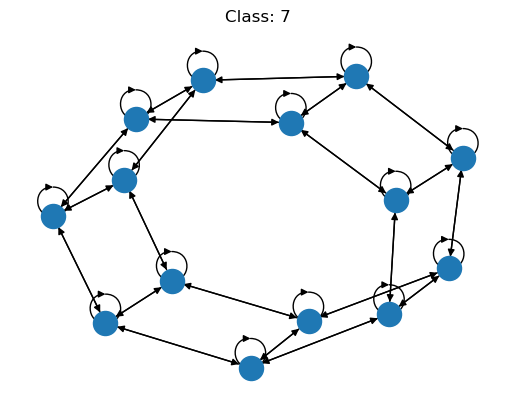

In [3]:
visualset = MiniGCDataset(8, 10, 20)

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = visualset[c] 
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Implementation of GatedGCNs with DGL

Residual Gated Graph ConvNets, X Bresson, T Laurent, ICLR 2017, [arXiv:1711.07553](https://arxiv.org/pdf/1711.07553v2.pdf) <br>


\begin{eqnarray}
h_i^{\ell+1} &=& h_i^{\ell} + \text{ReLU} \left( A^\ell h_i^{\ell} +  \sum_{j\sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \right), \quad \eta(e_{ij}^{\ell}) = \frac{\sigma(e_{ij}^{\ell})}{\sum_{j'\sim i} \sigma(e_{ij'}^{\ell}) + \varepsilon} \\
e_{ij}^{\ell+1} &=& e^\ell_{ij} + \text{ReLU} \Big( C^\ell e_{ij}^{\ell} + D^\ell h^{\ell+1}_i + E^\ell h^{\ell+1}_j  \Big)
\end{eqnarray}


In [4]:

class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
        
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GatedGCN_layer, self).__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh'] 
        e_ij = edges.data['Ce'] +  edges.src['Dh'] + edges.dst['Eh'] # e_ij = Ce_ij + Dhi + Ehj
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij'] 
        sigma_ij = torch.sigmoid(e) # sigma_ij = sigmoid(e_ij)
        h = Ah_i + torch.sum( sigma_ij * Bh_j, dim=1 ) / torch.sum( sigma_ij, dim=1 )  # hi = Ahi + sum_j eta_ij * Bhj    
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) 
        g.update_all(self.message_func,self.reduce_func) 
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph node size
        e = e* snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e
    
    
class GatedGCN_Net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GatedGCN_Net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([ GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h,e = GGCN_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update

    

    

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 100
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 2

# instantiate network
net = GatedGCN_Net(net_parameters)
print(net)


GatedGCN_Net(
  (embedding_h): Linear(in_features=1, out_features=100, bias=True)
  (embedding_e): Linear(in_features=1, out_features=100, bias=True)
  (GatedGCN_layers): ModuleList(
    (0): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, bias=True)
      (E): Linear(in_features=100, out_features=100, bias=True)
      (bn_node_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=1

# Test forward pass

In [5]:

train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print(batch_snorm_n.size())
print(batch_snorm_e.size())

batch_x = batch_graphs.ndata['feat']
print('batch_x',batch_x.size())

batch_e = batch_graphs.edata['feat']
print('batch_e',batch_e.size())

batch_snorm_n = batch_snorm_n
print('batch_snorm_n',batch_snorm_n.size())

batch_snorm_e = batch_snorm_e
print('batch_snorm_e',batch_snorm_e.size())

batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())

batch_labels = batch_labels
accuracy = net.accuracy(batch_scores,batch_labels)
print(accuracy)


Graph(num_nodes=134, num_edges=844,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
tensor([5, 5, 7, 6, 6, 0, 0, 4, 2, 5])
torch.Size([134, 1])
torch.Size([844, 1])
batch_x torch.Size([134, 1])
batch_e torch.Size([844, 1])
batch_snorm_n torch.Size([134, 1])
batch_snorm_e torch.Size([844, 1])
torch.Size([10, 8])
2.0


# Test backward pass

In [6]:

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005

# Loss
loss = net.loss(batch_scores, batch_labels)

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()
loss.backward()
optimizer.step()


# Train one epoch

In [7]:

def train_one_epoch(net, data_loader):
    """
    train one epoch
    """
    net.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_e = batch_graphs.edata['feat']
        batch_snorm_n = batch_snorm_n
        batch_snorm_e = batch_snorm_e
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        loss = net.loss(batch_scores, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_train_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data
    return epoch_loss, epoch_train_acc  


# Evaluation

In [8]:

def evaluate_network(net, data_loader):
    """
    evaluate test set
    """
    net.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0
    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_x = batch_graphs.ndata['feat']
            batch_e = batch_graphs.edata['feat']
            batch_snorm_n = batch_snorm_n
            batch_snorm_e = batch_snorm_e
            batch_labels = batch_labels
            batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
            loss = net.loss(batch_scores, batch_labels)
            epoch_test_loss += loss.detach().item()
            epoch_test_acc += net.accuracy(batch_scores,batch_labels)
            nb_data += batch_labels.size(0)
        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data
    return epoch_test_loss, epoch_test_acc
    

# Train GNN

In [9]:

# datasets
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Create model
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 100
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_Net(net_parameters)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_test_accs = []
epoch_val_accs = []
for epoch in range(50):
    
    start = time.time()
    epoch_train_loss, epoch_train_acc = train_one_epoch(net, train_loader)
    epoch_test_loss, epoch_test_acc = evaluate_network(net, test_loader)
    epoch_val_loss, epoch_val_acc = evaluate_network(net, val_loader)
        
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f} \n                     train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss, epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Epoch 0, time 1.6418, train_loss: 2.0092, test_loss: 2.0319, val_loss: 2.0319 
                     train_acc: 0.2343, test_acc: 0.1200, val_acc: 0.1200
Epoch 1, time 1.6794, train_loss: 1.9021, test_loss: 1.9863, val_loss: 1.9863 
                     train_acc: 0.3943, test_acc: 0.1200, val_acc: 0.1200
Epoch 2, time 1.7416, train_loss: 1.8032, test_loss: 1.9217, val_loss: 1.9217 
                     train_acc: 0.3771, test_acc: 0.2600, val_acc: 0.2600
Epoch 3, time 1.7690, train_loss: 1.7355, test_loss: 1.8438, val_loss: 1.8438 
                     train_acc: 0.3771, test_acc: 0.3500, val_acc: 0.3500
Epoch 4, time 1.7733, train_loss: 1.6713, test_loss: 1.7568, val_loss: 1.7568 
                     train_acc: 0.4314, test_acc: 0.3600, val_acc: 0.3600
Epoch 5, time 1.4200, train_loss: 1.6167, test_loss: 1.6712, val_loss: 1.6712 
                     train_acc: 0.5029, test_acc: 0.3700, val_acc: 0.3700
Epoch 6, time 1.7266, train_loss: 1.5380, test_loss: 1.5942, val_loss: 1.5942 
   